# Evolution de la politique d'augmentation de données

Cette fois nous ferons plus attention à ne pas introduire des images du dataset de test dans le dataset d'entraînement, même si elles sont modifiées.

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

import albumentations as alb

import tensorflow as tf
from tensorflow.keras import layers

2024-06-16 07:35:06.728081: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 07:35:06.729953: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 07:35:06.760199: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 07:35:06.880659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 07:35:07.546406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

#### Fonctions utilitaires pour parcourir les images

In [2]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train", "val", "test"]
categories = ["NORMAL", "PNEUMONIA"]


# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback=None, limit_size=None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path, file_name)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                img_callback(img, category)


def display_imgs(imgs, titles=[], plot_size=(1, 1), figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index)
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

### we can perform different type of transformations on the images

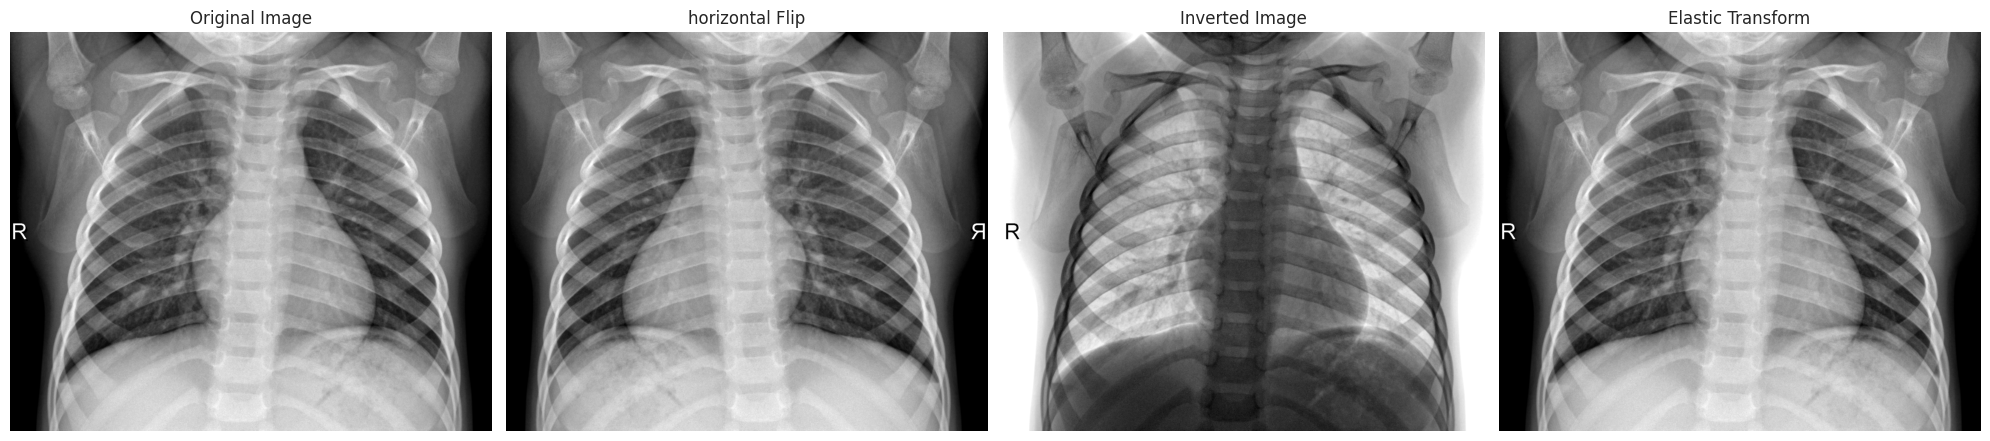

In [3]:
imgs = []
titles = []

image_path = "chest_Xray/train/NORMAL/NORMAL2-IM-0385-0001.jpeg"
imgs.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
titles.append("Original Image")

imgs.append(alb.hflip(imgs[0]))
titles.append("horizontal Flip")
imgs.append(alb.InvertImg().apply(imgs[0]))
titles.append("Inverted Image")
distortion = alb.GridDistortion(num_steps=222, distort_limit=0.95, border_mode=cv2.BORDER_CONSTANT, p=0.3)
elastic = alb.ElasticTransform(alpha=1, sigma=100, alpha_affine=100, p=0.9)
imgs.append(elastic(image=imgs[0])['image'])
titles.append("Elastic Transform")

display_imgs(imgs, titles, plot_size=(4, 4), figsize=(20, 20))

### Préparation des datasets

In [4]:
original_datasetX = []
original_datasetY = []
augmented_normal_datasetX = []
augmented_normal_datasetY = []
augmented_pneumonia_datasetX = []
augmented_pneumonia_datasetY = []

test_datasetX = []
test_datasetY = []

image_size = (200, 200)


def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    original_datasetX.append(new_img)
    # replace normal with 0 and pneumonia with 1 in order to have numerical labels
    category = 0 if category == "NORMAL" else 1
    original_datasetY.append(category)

browse_imgs(load_datasets)

# après avoir chargé le dataset, on met directement de coté les images de test afin d'être sûr de ne pas les modifier
original_datasetX, test_datasetX, original_datasetY, test_datasetY = train_test_split(original_datasetX, original_datasetY, test_size=0.2, random_state=1)

for i in range(0, len(original_datasetX)):
    image = original_datasetX[i]
    category = original_datasetY[i]
    first_transformed_img = alb.hflip(image)
    second_transformed_img = elastic(image=imgs[0])['image']    
    
    if category == 0:
        augmented_normal_datasetX.append(first_transformed_img)
        augmented_normal_datasetY.append(category)
        augmented_normal_datasetX.append(second_transformed_img)
        augmented_normal_datasetY.append(category)

    else:
        augmented_pneumonia_datasetX.append(first_transformed_img)
        augmented_pneumonia_datasetY.append(category)
        augmented_pneumonia_datasetX.append(second_transformed_img)
        augmented_pneumonia_datasetY.append(category)

# normalizing the images
original_datasetX = np.array(original_datasetX) / 255
original_datasetY = np.array(original_datasetY)
test_datasetX = np.array(test_datasetX) / 255
test_datasetY = np.array(test_datasetY)
augmented_normal_datasetX = np.array(augmented_normal_datasetX) / 255
augmented_normal_datasetY = np.array(augmented_normal_datasetY)
augmented_pneumonia_datasetX = np.array(augmented_pneumonia_datasetX) / 255
augmented_pneumonia_datasetY = np.array(augmented_pneumonia_datasetY)

# la seed nous permettra de mélanger les datasets X et Y de la même manière
random_seed = 5

KeyboardInterrupt: 

In [ ]:
def display_distribution(datasetsY, datasets_names):
    fig, ax = plt.subplots(1, len(datasetsY), figsize=(5 * len(datasetsY), 5))
    #iterate on each datasetY to count the number of each category
    for index, datasetY in enumerate(datasetsY):
        dataset = datasetY.tolist()
        ax[index].bar(["NORMAL", "PNEUMONIA"], [dataset.count(0), dataset.count(1)])
        ax[index].set_title(datasets_names[index])
        
    plt.show()


display_distribution([test_datasetY,
                      original_datasetY,
                      np.concatenate((augmented_normal_datasetY,np.concatenate((original_datasetY, augmented_pneumonia_datasetY)))),
                      np.concatenate((original_datasetY, augmented_normal_datasetY)),
                      np.concatenate((original_datasetY, augmented_pneumonia_datasetY))],
                     ["test_dataset", "original_dataset", "augmented_dataset", "augmented_normal_dataset", "augmented_pneumonia_dataset"])

### On doit faire attention à bien tester uniquement avec des données originales pour être sûr de nos résultats

#### CNN - Convolution Neural Network

Convolution = mettre en évidence les caractéristiques de l'image.

Poolling = réduire l'image.

In [ ]:
# This line sets the number of output classes for your model
num_classes = 1
# This line sets the size of the kernel to be used in the convolutional layers. The kernel is
# a small matrix that is used for blurring, sharpening, embossing, edge detection, and more
core_size = 4

# he Sequential model is a linear stack of layers that you can add to in order
model = tf.keras.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(256, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, core_size, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['recall'])

In [ ]:
def train_and_test_with_confusion_matrix(datasetX, datasetY):
    model.fit(datasetX,
          datasetY,
          validation_data=(test_datasetX, test_datasetY),
          epochs=2)
    
    y_pred = model.predict(test_datasetX)
    # Convert probabilities to class labels
    y_pred_label = np.round(y_pred).astype(int)
    
    cm = confusion_matrix(test_datasetY, y_pred_label)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
    plt.show()
    
    recall = recall_score(test_datasetY, y_pred_label)
    precision = precision_score(test_datasetY, y_pred_label)
    f1score = f1_score(test_datasetY, y_pred_label)
    print("recall : ", recall)
    print("precision : ", precision)
    print("f1score : ", f1score)

### testing model on original dataset

In [ ]:
train_and_test_with_confusion_matrix(original_datasetX, original_datasetY)

### testing model on augmented dataset

In [ ]:
x = np.concatenate((augmented_normal_datasetX,np.concatenate((original_datasetX, augmented_pneumonia_datasetX))))
np.random.seed(random_seed)
np.random.shuffle(x)
y = np.concatenate((augmented_normal_datasetY,np.concatenate((original_datasetY, augmented_pneumonia_datasetY))))
np.random.seed(random_seed)
np.random.shuffle(y)
train_and_test_with_confusion_matrix(x, y)

### testing model on augmented normal dataset (only normal images are augmented in order to balance the dataset)

In [ ]:
x = np.concatenate((original_datasetX, augmented_normal_datasetX))
np.random.seed(random_seed)
np.random.shuffle(x)
y = np.concatenate((original_datasetY, augmented_normal_datasetY))
np.random.seed(random_seed)
np.random.shuffle(y)
train_and_test_with_confusion_matrix(x, y)

### testing model on augmented pneumonia dataset (only pneumonia images are augmented in order to focus on pneumonia detection)

In [ ]:
x = np.concatenate((original_datasetX, augmented_pneumonia_datasetX))
np.random.seed(random_seed)
np.random.shuffle(x)
y = np.concatenate((original_datasetY, augmented_pneumonia_datasetY))
np.random.seed(random_seed)
np.random.shuffle(y)
train_and_test_with_confusion_matrix(x, y)